# Training a Convolutional Neural Network

In [8]:
import os
import tensorflow as tf
import keras
import pandas as pd
import keras_tuner as kt
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import cv2 as cv

from tqdm import trange
from scripts.dataset import Dataset

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
sns.set_theme(palette=sns.color_palette("rocket_r"))

Num GPUs Available:  1


In [9]:
CURRENT_PATH = os.getcwd()

DATASET_PATH = os.path.join(CURRENT_PATH, "dataset.csv")
EXPERIMENT_PATH = os.path.join(CURRENT_PATH, '__experiments__')
EXPERIMENT_NAME = "cnn_model"
MODEL_PATH = os.path.join(EXPERIMENT_PATH, EXPERIMENT_NAME, "cnn_model.keras")

# Trainig Parameters
BATCH_SIZE = 8
EPOCHS = 100
PATIENCE = 20
IMAGE_WIDTH = 224
IMAGE_HEIGHT = 224
IMAGE_CHANNEL = 3

## Preparing the dataset

In [10]:
assert os.path.isfile(DATASET_PATH), "Dataset not exists. Please run the previous notebook."
train_dataset = Dataset(dataset_path=DATASET_PATH, dataset_mode="csv", partition_name="train", preload=True)
val_dataset = Dataset(dataset_path=DATASET_PATH, dataset_mode="csv", partition_name="val", preload=True)
test_dataset = Dataset(dataset_path=DATASET_PATH, dataset_mode="csv", partition_name="test", preload=True)

[LOG] Importing data from c:\Users\limag\projects\si\vlm_garbage_classification\dataset.csv, mode = csv
[LOG] Filtered by partition = train
[LOG] Preloading the dataset


100%|██████████| 1616/1616 [00:01<00:00, 1040.59it/s]


[LOG] Importing data from c:\Users\limag\projects\si\vlm_garbage_classification\dataset.csv, mode = csv
[LOG] Filtered by partition = val
[LOG] Preloading the dataset


100%|██████████| 405/405 [00:00<00:00, 1167.64it/s]


[LOG] Importing data from c:\Users\limag\projects\si\vlm_garbage_classification\dataset.csv, mode = csv
[LOG] Filtered by partition = test
[LOG] Preloading the dataset


100%|██████████| 506/506 [00:00<00:00, 1181.18it/s]


In [11]:
def as_numpy(dataset: Dataset):
    n = len(dataset)
    iterator = iter(dataset)
    x = np.ndarray(shape=(n, IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNEL), dtype=np.float64)
    y = np.ndarray(shape=(n,), dtype=np.int8)
    for index in trange(n):
        xi, yi, _ = next(iterator)
        xi = cv.resize(xi, [IMAGE_WIDTH, IMAGE_HEIGHT])
        x[index] = xi
        y[index] = yi
    return x, y

x_train, y_train = as_numpy(train_dataset)
x_val, y_val = as_numpy(val_dataset)
x_test, y_test = as_numpy(test_dataset)

print(f"Image Shape = {x_train[0].shape}")

100%|██████████| 506/506 [00:00<00:00, 3155.60it/s]


Image Shape = (224, 224, 3)


## Training

In [12]:
def build_model(hp: kt.HyperParameters):
    dense_unit = hp.Choice('dense_unit', [16, 32, 64])
    
    input_shape = (IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNEL)
    base_model = keras.applications.EfficientNetV2B2(input_shape=input_shape, include_top=False, pooling="max")
    
    data_augmentation = keras.Sequential([
        keras.layers.RandomRotation(0.2),
        keras.layers.RandomFlip("horizontal_and_vertical"),
    ])
    
    model = keras.Sequential([
        data_augmentation,
        keras.layers.Input(shape=input_shape),
        base_model,
        keras.layers.Dense(dense_unit, activation="relu"),
        keras.layers.Dense(dense_unit, activation="relu"),
        keras.layers.Dense(6, activation="softmax")
    ])
    return model

def compile_model(hp: kt.HyperParameters, model: keras.Sequential):
    learning_rate = hp.Choice('learning_rate', [0.1, 0.01, 0.001])
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(
        optimizer=optimizer,
        loss=keras.losses.SparseCategoricalCrossentropy(),
        metrics=[keras.metrics.SparseCategoricalAccuracy("accuracy")]
    )
    
def create_model(hp: kt.HyperParameters):
    model = build_model(hp)
    compile_model(hp, model)
    return model

In [13]:
early_stopping_callback = keras.callbacks.EarlyStopping("val_loss", patience=PATIENCE, restore_best_weights=True)

tuner = kt.Hyperband(
    create_model,
    objective=kt.Objective("val_loss", direction="min"),
    project_name=EXPERIMENT_NAME,
    overwrite=False,
    directory=EXPERIMENT_PATH
)

# Training...
tuner.search(x_train, 
             y_train,
             validation_data=(x_val, y_val),
             epochs=EPOCHS,
             batch_size=BATCH_SIZE,
             callbacks=[early_stopping_callback])

Reloading Tuner from c:\Users\limag\projects\si\vlm_garbage_classification\__experiments__\cnn_model\tuner0.json


In [14]:
best_hps = tuner.get_best_hyperparameters(1)[0]
best_model = create_model(best_hps)
history = best_model.fit(x_train, 
                        y_train,
                        validation_data=(x_val, y_val),
                        epochs=EPOCHS,
                        batch_size=BATCH_SIZE,
                        callbacks=[early_stopping_callback])

Epoch 1/100
202/202 [==============================] - 33s 91ms/step - loss: 1.2711 - accuracy: 0.5637 - val_loss: 0.7869 - val_accuracy: 0.7136
Epoch 2/100
202/202 [==============================] - 17s 84ms/step - loss: 0.9500 - accuracy: 0.6553 - val_loss: 0.6954 - val_accuracy: 0.7728
Epoch 3/100
202/202 [==============================] - 17s 82ms/step - loss: 0.8490 - accuracy: 0.7073 - val_loss: 0.7677 - val_accuracy: 0.7333
Epoch 4/100
202/202 [==============================] - 17s 86ms/step - loss: 0.8296 - accuracy: 0.7079 - val_loss: 0.6055 - val_accuracy: 0.8395
Epoch 5/100
202/202 [==============================] - 18s 89ms/step - loss: 0.7249 - accuracy: 0.7537 - val_loss: 0.5479 - val_accuracy: 0.8123
Epoch 6/100
202/202 [==============================] - 19s 94ms/step - loss: 0.6426 - accuracy: 0.7933 - val_loss: 0.6661 - val_accuracy: 0.7531
Epoch 7/100
202/202 [==============================] - 18s 89ms/step - loss: 0.6094 - accuracy: 0.8045 - val_loss: 0.5220 - val_ac

In [15]:
best_model.save(MODEL_PATH)
best_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_2 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 input_4 (InputLayer)        multiple                  0         
                                                                 
 efficientnetv2-b2 (Function  (None, 1408)             8769374   
 al)                                                             
                                                                 
 dense_3 (Dense)             (None, 64)                90176     
                                                                 
 dense_4 (Dense)             (None, 64)                4160      
                                                                 
 dense_5 (Dense)             (None, 6)                 390       
                                                      

## Evaluating the model

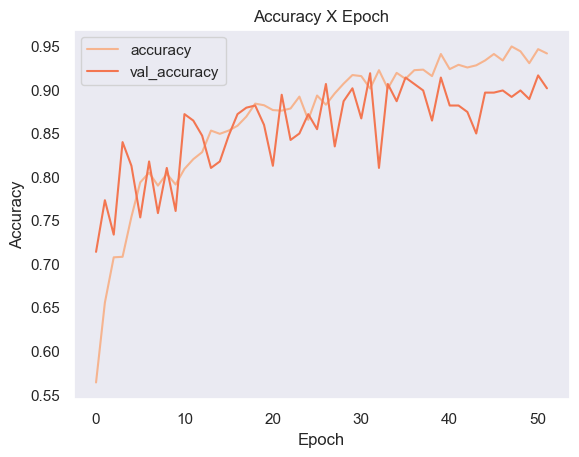

In [16]:
plt.title("Accuracy X Epoch")
plt.plot(history.history['accuracy'], label="accuracy")
plt.plot(history.history['val_accuracy'], label="val_accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(False)
plt.legend()
plt.show()

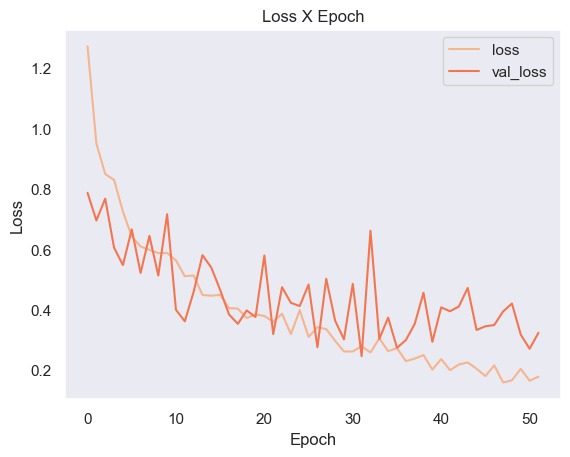

In [17]:
plt.title("Loss X Epoch")
plt.plot(history.history['loss'], label="loss")
plt.plot(history.history['val_loss'], label="val_loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(False)
plt.legend()
plt.show()

In [18]:
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score, confusion_matrix
from prettytable import PrettyTable

def plot_metrics(y_true: np.array, y_pred: np.array):
    table = PrettyTable(["Metric", "Value (%)"])
    
    # Calculating metrics...
    accuracy = accuracy_score(y_true, y_pred) * 100
    precision = precision_score(y_true, y_pred, average='macro', zero_division=0.0) * 100
    recall = recall_score(y_true, y_pred, average='macro', zero_division=0.0) * 100
    f1 = f1_score(y_true, y_pred, average='macro', zero_division=0.0) * 100

    table.add_row(['Accuracy', f"{accuracy:.2f}%"])
    table.add_row(['Precision', f"{precision:.2f}%"])
    table.add_row(['Recall', f"{recall:.2f}%"])
    table.add_row(['F1 Score', f"{f1:.2f}%"])
    
    print(table)

def plot_cm(y_true: np.array, y_pred: np.array):
    plt.figure(figsize=(8,6))
    cm = confusion_matrix(y_true, y_pred)
    plt.title(f'Confusion Matrix')
    sns.heatmap(cm, annot=True, cmap=sns.color_palette("rocket_r", as_cmap=True), fmt='.0f', yticklabels=test_dataset.classes, xticklabels=test_dataset.classes)
    plt.show()

In [19]:
y_pred = best_model.predict(x_test, verbose=False)
y_pred = np.array([np.argmax(y) for y in y_pred])

+-----------+-----------+
|   Metric  | Value (%) |
+-----------+-----------+
|  Accuracy |   89.72%  |
| Precision |   88.71%  |
|   Recall  |   88.19%  |
|  F1 Score |   88.36%  |
+-----------+-----------+


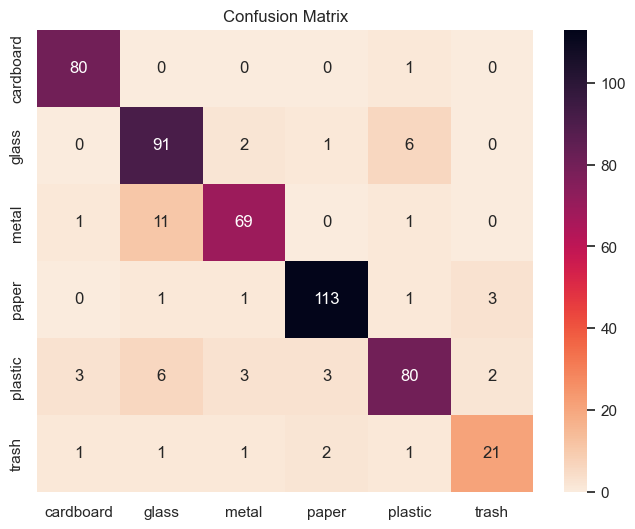

In [20]:
plot_metrics(y_test, y_pred)
plot_cm(y_test, y_pred)

Visualizing some errors

In [21]:
errors = []
for index in range(len(y_pred)):
    true = y_test[index] 
    pred = y_pred[index]
    if true != pred:
        errors.append((x_test[index], true, pred))

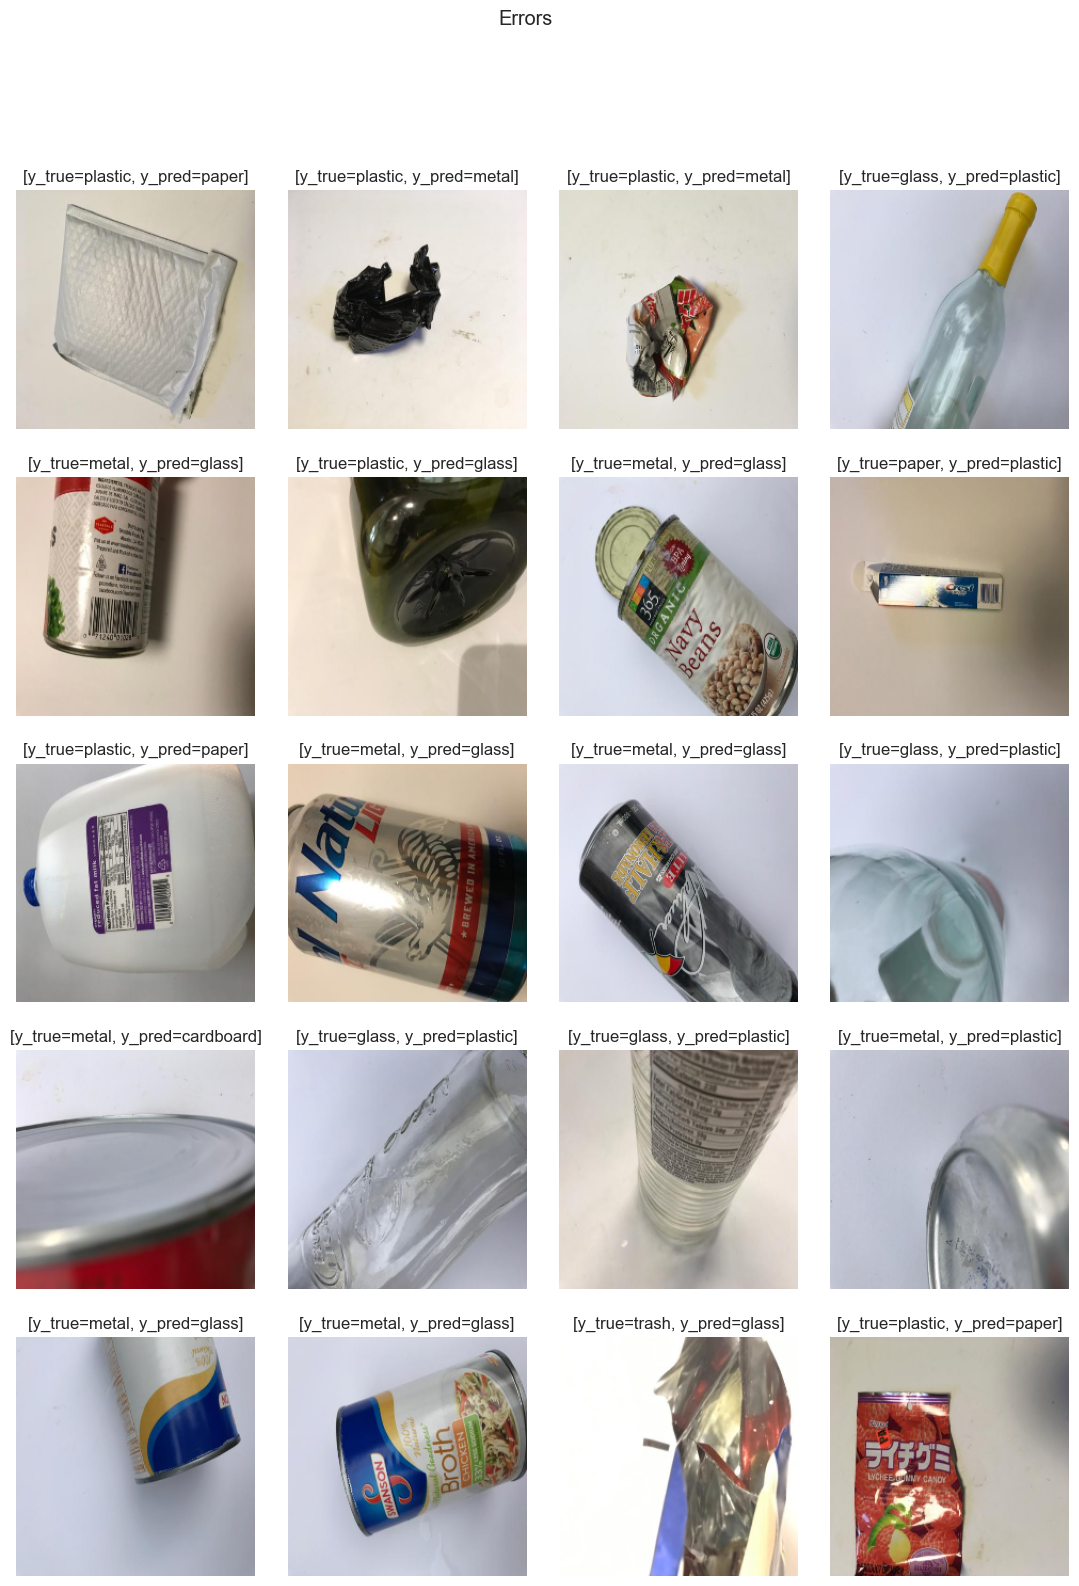

In [22]:
nrows = 5
ncols = 4

figure, axis = plt.subplots(nrows, ncols, squeeze=False, figsize=(14,18))
figure.suptitle(f"Errors")
axes = []
for ax in axis:
    axes += [*ax]
for index in range(nrows * ncols):
    ax = axes[index]
    x, true_class, pred = errors[index]
    pred = test_dataset.decode_label(pred)
    true_class = test_dataset.decode_label(true_class)
    ax.axis("off")
    ax.set_title(f"[y_true={true_class}, y_pred={pred}]")
    ax.imshow(x.astype(np.int64))
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    
plt.subplots_adjust(wspace=0, hspace=.2)
plt.show()